# Simple DQN on Keras
The DQN Algorithm solves the issues related to the function approximations with Neural Networks:
* Bootstrap issue (Estimation with an estimation)
* Uncorrelate samples of experiences to facilitate Gradient Descent

![alt text](imgs/DQN.png "DQN")

<img src="imgs/dqn_algo.png" alt="Algorithm DQN" style="width: 600px;"/>

### Act Greedy
$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$

### Target Error
$\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))$

### References
* https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
* https://stackoverflow.com/questions/51960225/dqn-average-reward-decrease-after-training-for-a-period-of-time
* https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
* https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
import gym
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

## Plot function
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_durations(durations_t):
    plt.figure(2)
    plt.clf()    
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.plot(durations_t)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:        
        plt.plot(moving_average(durations_t,20))

### Define Hyperparameters

In [2]:
train_episodes = 600              # max number of episodes to learn from
max_steps = 200                   # max steps in an episode
gamma = 0.99                      # future reward discount

# Exploration parameters
explore_start = 1.0               # exploration probability at start (Pure exploratory)
explore_stop = 0.01               # minimum exploration probability
decay_rate = 0.0001               # exponential decay rate for exploration prob

# Network parameters
hidden_size = 16                  # number of units in each Q-network hidden layer
learning_rate = 0.001             # Q-network learning rate

# Memory parameters
memory_size = 10000               # memory capacity
batch_size = 32                   # experience mini-batch size
pretrain_length = batch_size*10   # number experiences to pretrain the memory

consecutive_win_threshold = 6     # Number of Consecutive wins before stop training
target_updates = 5

### Define Q-Network

In [3]:
class QNetwork:
    def __init__(self, env, learning_rate=0.01, state_size=4,
                 hidden_size=10):
        action_size = env.action_space.n
        # state inputs to the Q-network
        self.model = Sequential()

        self.model.add(Dense(hidden_size, activation='relu',
                             input_dim=state_size))
        self.model.add(Dense(hidden_size, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))

        self.optimizer = Adam(lr=learning_rate)#, decay=1e-6)
        self.model.compile(loss='mse', optimizer=self.optimizer)
    
    def __call__(self, state):
        # Reshape states (,4) --> [1,4]
        state = np.expand_dims(state, axis=0)
        # Get Q-values
        Q_values = self.model.predict(state)[0]
        # Act greedly
        action = np.argmax(Q_values)
        return action
    
    def q_values(self, state):
        # Reshape states (,4) --> [1,4]
        state = np.expand_dims(state, axis=0)
        # Get Q-values
        Q_values = self.model.predict(state)
        return Q_values
    
    def set_weights(self, weights):
        self.model.set_weights(weights)
    
    def get_weights(self):
        return self.model.get_weights()


# Initialize DQN Network
mainQN = QNetwork(env, hidden_size=hidden_size, learning_rate=learning_rate)
targetQ = QNetwork(env, hidden_size=hidden_size, learning_rate=learning_rate)
targetQ.set_weights(mainQN.get_weights()) 


### Memory Buffer

In [4]:
class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)
    
    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

memory = Memory(max_size=memory_size)

### Training

In [5]:
# Initialize the simulation
state = env.reset()
rewards_per_episode = []

step = 0
num_consecutive_win = 0

# For each episodes
for i_episode in range(1, train_episodes):
    total_reward = 0
    t = 0
    # Update the target network, copying all weights and biases in DQN
    if i_episode % target_updates == 0:
        targetQ.set_weights(mainQN.get_weights()) 
        
    # For each iteration per episode.
    while t < max_steps:
        step += 1
     
        # Epsilon Greedy Decay
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
        
        # Epsilon Greedy
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            action = mainQN(state)

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)        
        total_reward += reward

        # Episode finish
        if done:
            # the episode ends so no next state
            next_state = np.zeros(state.shape)
            t = max_steps

            print('DONE! Episode: {}'.format(i_episode),
                  'Total reward: {}'.format(total_reward),
                  'Explore P: {:.4f}'.format(explore_p))
            
            rewards_per_episode.append(total_reward)
            
            # Early Stop
            if total_reward >= 199:
                num_consecutive_win += 1
                print('Win...')
            else:
                num_consecutive_win = 0                
            
            if num_consecutive_win > consecutive_win_threshold:                
                break

            # Add experience to memory
            memory.add((state, action, reward, next_state))

            # Start new episode
            env.reset()            
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            t += 1

        # Check if we have enough samples on memory to sample
        if len(memory) >= batch_size:
            # Sample experience from Replay Memory
            minibatch = memory.sample(batch_size)
        else:
            # Keep populating replay memory
            print('Populating replay buffer')
            continue
        
        # Get inputs (states) and calculate targets         
        inputs = np.zeros((batch_size, 4))
        targets = np.zeros((batch_size, 2))
        for i, (state_b, action_b, reward_b, next_state_b) in enumerate(minibatch):
            inputs[i:i+1] = state_b
            target = reward_b
            # Check if all elements from next next_state_b are different than zero
            if not (next_state_b == np.zeros(state_b.shape)).all(axis=0):                
                target = reward_b + gamma * np.amax(targetQ.q_values(next_state_b)[0])
            targets[i] = targetQ.q_values(state_b)
            targets[i][action_b] = target
        
        # Update the model (In each episode end)
        mainQN.model.fit(inputs, targets, epochs=1, verbose=0)
    
    # Stop Earlier ...
    if num_consecutive_win > consecutive_win_threshold:
        print('Number of consecutive wins high, stop earlier...')
        break

Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 1 Total reward: 17.0 Explore P: 0.9983
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 2 Total reward: 38.0 Explore P: 0.9946
DONE! Episode: 3 Total reward: 24.0 Explore P: 0.9922
DONE! Episode: 4 Total reward: 14.0 Explore P: 0.9908
DONE! Epi

DONE! Episode: 136 Total reward: 46.0 Explore P: 0.7033
DONE! Episode: 137 Total reward: 22.0 Explore P: 0.7017
DONE! Episode: 138 Total reward: 43.0 Explore P: 0.6988
DONE! Episode: 139 Total reward: 10.0 Explore P: 0.6981
DONE! Episode: 140 Total reward: 40.0 Explore P: 0.6953
DONE! Episode: 141 Total reward: 91.0 Explore P: 0.6891
DONE! Episode: 142 Total reward: 30.0 Explore P: 0.6871
DONE! Episode: 143 Total reward: 12.0 Explore P: 0.6863
DONE! Episode: 144 Total reward: 100.0 Explore P: 0.6795
DONE! Episode: 145 Total reward: 35.0 Explore P: 0.6772
DONE! Episode: 146 Total reward: 69.0 Explore P: 0.6726
DONE! Episode: 147 Total reward: 86.0 Explore P: 0.6669
DONE! Episode: 148 Total reward: 32.0 Explore P: 0.6648
DONE! Episode: 149 Total reward: 46.0 Explore P: 0.6618
DONE! Episode: 150 Total reward: 25.0 Explore P: 0.6602
DONE! Episode: 151 Total reward: 54.0 Explore P: 0.6567
DONE! Episode: 152 Total reward: 30.0 Explore P: 0.6548
DONE! Episode: 153 Total reward: 52.0 Explore P

### Plot Total Rewards per Episode

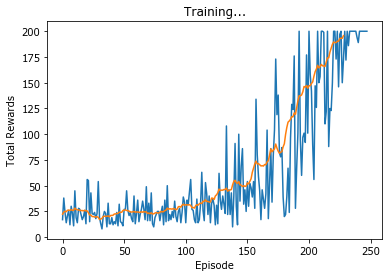

In [6]:
plot_durations(rewards_per_episode)

### Test trained Agent

In [7]:
# Reset environment
state = env.reset()

while True:    
    # Act greedly
    action = mainQN(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break